In [1]:
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from utils import *

%matplotlib inline

2023-07-10 11:17:46.349879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 11:17:52.856643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["PYTHONHASHSEED"] = "0"
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
x = []
y = []

f = open("12_06_2023_14_27_16.csv", "r")

for line in f.readlines():
    ps = [[aux for aux in p[1:-2].split(" ") if len(aux)>0] for p in line.split(",")]
    x.append([[float(p[0]), float(p[1]), float(p[2])] for p in ps])
    y.append(0)

f.close()

f = open("12_06_2023_14_30_18.csv", "r")

for line in f.readlines():
    ps = [[aux for aux in p[1:-2].split(" ") if len(aux)>0] for p in line.split(",")]
    x.append([[float(p[0]), float(p[1]), float(p[2])] for p in ps])
    y.append(1)

f.close()

f = open("12_06_2023_15_14_35.csv", "r")

for line in f.readlines():
    ps = [[aux for aux in p[1:-2].split(" ") if len(aux)>0] for p in line.split(",")]
    x.append([[float(p[0]), float(p[1]), float(p[2])] for p in ps])
    y.append(2)

f.close()

x = np.array(x)
#x = x[:,:,0:2]
y = np.array(y)

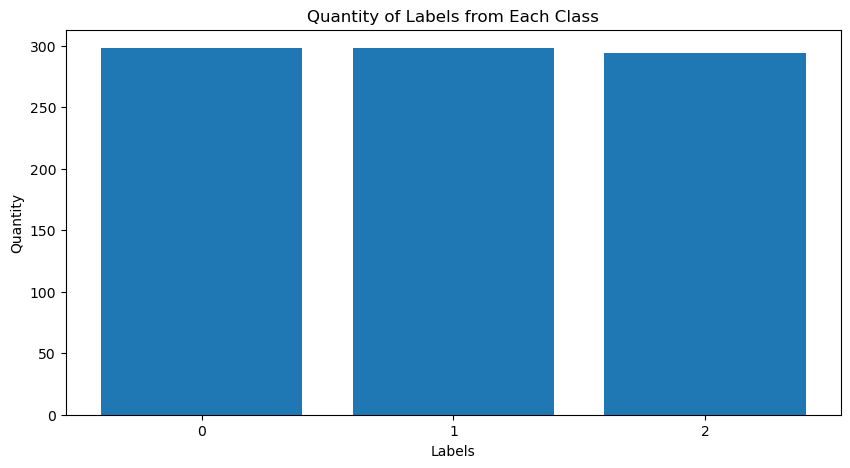

[0 1 2]
3


In [4]:
draw_bar_chart(y)

print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

In [5]:
# shuffle
x, y = shuffle(x, y, random_state=0)

# split
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=1/5, random_state=0, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=1/4, random_state=0, stratify=y_temp)

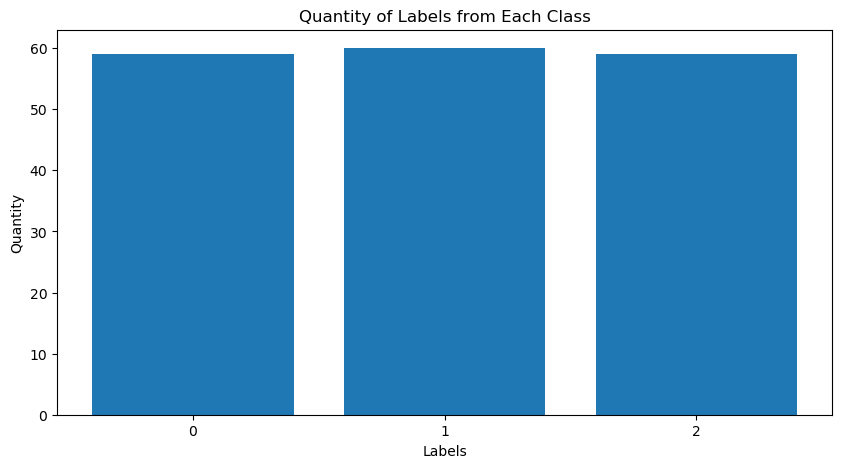

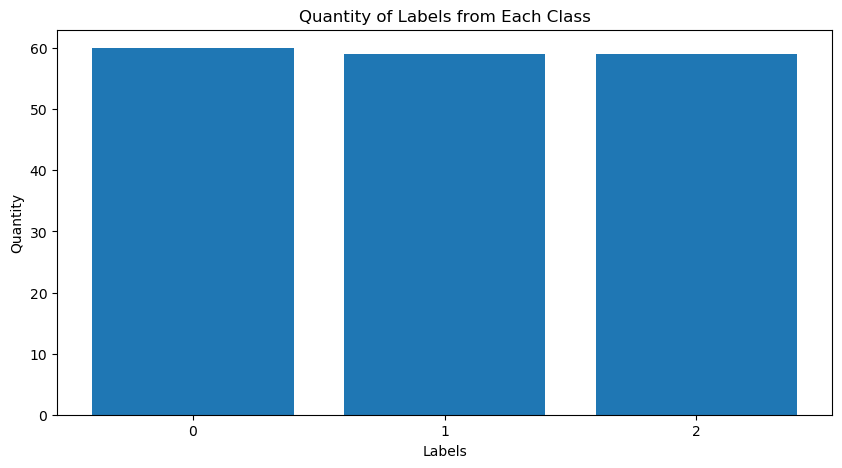

In [6]:
draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [8]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [9]:
input_shape = x.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"]
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=10000,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_val, y_val, verbose=1)

model.evaluate(x_test, y_test, verbose=1)

2023-07-10 11:18:05.238803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 11:18:05.441555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 11:18:05.442401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 3)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 21, 3)       6           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 21, 3)       15363       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2023-07-10 11:18:25.554575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-10 11:18:27.914739: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f75f000c590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-10 11:18:27.914867: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-07-10 11:18:28.421344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-10 11:18:30.183031: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 24s 163ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.3296 - val_loss: 1.0975 - val_sparse_categorical_accuracy: 0.3090
Epoch 2/10000
9/9 [==============================] - 1s 64ms/step - loss: 1.1752 - sparse_categorical_accuracy: 0.3258 - val_loss: 1.0912 - val_sparse_categorical_accuracy: 0.4101
Epoch 3/10000
9/9 [==============================] - 1s 65ms/step - loss: 1.1638 - sparse_categorical_accuracy: 0.3277 - val_loss: 1.0798 - val_sparse_categorical_accuracy: 0.4551
Epoch 4/10000
9/9 [==============================] - 1s 62ms/step - loss: 1.1264 - sparse_categorical_accuracy: 0.3876 - val_loss: 1.0610 - val_sparse_categorical_accuracy: 0.4831
Epoch 5/10000
9/9 [==============================] - 1s 64ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.3539 - val_loss: 1.0543 - val_sparse_categorical_accuracy: 0.5281
Epoch 6/10000
9/9 [==============================] - 1s 60ms/step - loss: 1.1360 - sparse_categorical_accuracy: 

[0.3600241541862488, 0.882022500038147]

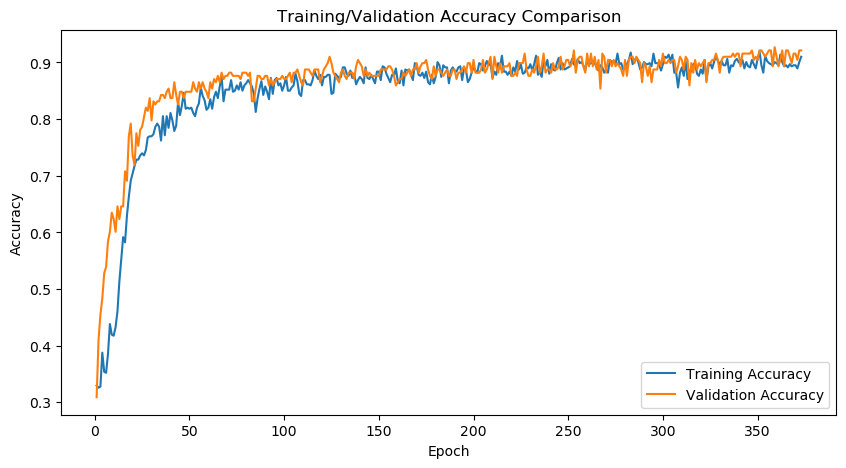

In [10]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

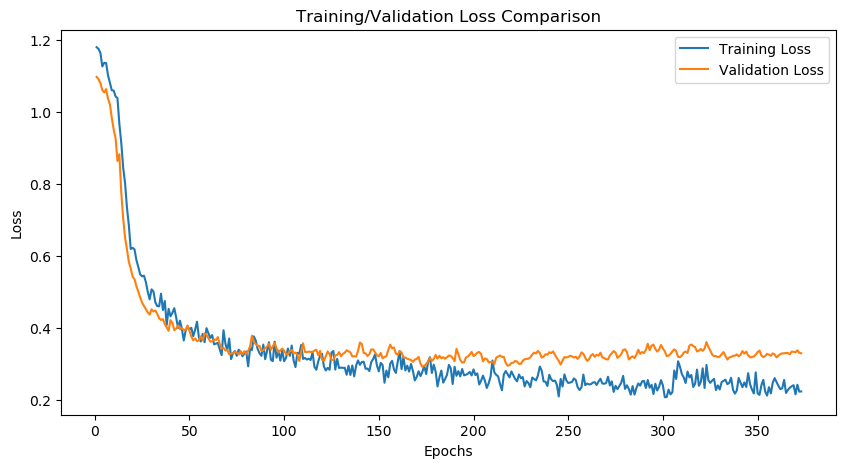

In [11]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

6/6 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0     0.9667    1.0000    0.9831        58
           1     0.9831    0.7532    0.8529        77
           2     0.6949    0.9535    0.8039        43

    accuracy                         0.8820       178
   macro avg     0.8815    0.9022    0.8800       178
weighted avg     0.9081    0.8820    0.8835       178



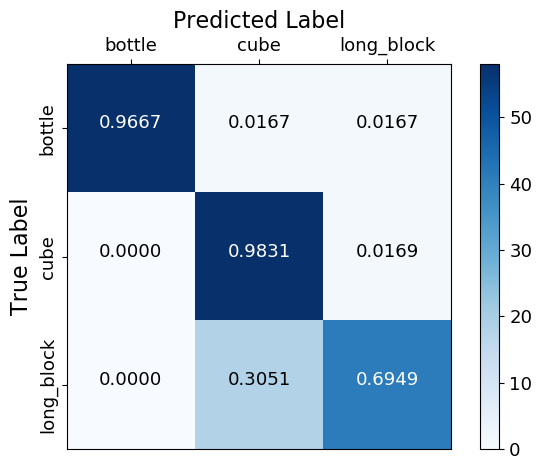

In [19]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_pred,y_test, digits=4))
plot_confusion_matrix(y_test, y_pred, ["bottle", "cube", "long_block"], save_path="transformer_dataset1_conf_matrix.svg")

In [13]:
# dropouts=[0.1 * _ for _ in range(6)]
# acc = []
# loss = []

# for d in dropouts:
#     model = fc_model(dropout=d)

#     model.compile(
#         loss="sparse_categorical_crossentropy",
#         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#         metrics=["sparse_categorical_accuracy"]
#     )

#     callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

#     results = model.fit(
#         x_train,
#         y_train,
#         validation_data=(x_val,y_val),
#         #validation_split=0.2,
#         epochs=100,
#         batch_size=16,
#         callbacks=callbacks,
#     )

#     acc.append(results.history["val_sparse_categorical_accuracy"])
#     loss.append(results.history["val_loss"])

In [14]:
# plot_accuracy_comparison(acc, "Dropout Comparison (Validation Accuracy)", dropouts)


In [15]:
# plot_loss_comparison(loss, "Dropout Comparison (Validation Loss)", dropouts)

In [16]:
# #a = np.array([0,1,0,0,1,0,0,1,0,0])
# #a = np.array([1,1,0,1,1,0,1,1,0,1])
# #a = np.array([2,2,0,2,2,1,2,2,3,2])
# a = np.array([7,7,0,7,7,3,7,7,6,7])

# a = a.reshape((1, a.shape[0],1))

# print(a.shape)

# model.predict(a)

In [17]:
# model.save('../models/points_conv_1d')

In [18]:
#model = tf.keras.models.load_model('../models/transformer_numbers')